Successfully loaded 'master_daily_data_cleaned_for_sleep_model.csv'.

Merging 'Good Sleep' and 'Okay Sleep' into a single class...
New distribution of binary target variable:
sleep_quality_binary
Poor Sleep        2508
Not Poor Sleep     647
Name: count, dtype: int64

Features scaled.

Training RandomForestClassifier on the binary data...
Model training complete.

--- Binary Model Test Set Performance ---
Classification Report (Test Set):
                precision    recall  f1-score   support

Not Poor Sleep       0.41      0.54      0.47       194
    Poor Sleep       0.87      0.80      0.83       753

      accuracy                           0.75       947
     macro avg       0.64      0.67      0.65       947
  weighted avg       0.78      0.75      0.76       947

Test Set Accuracy: 0.7476


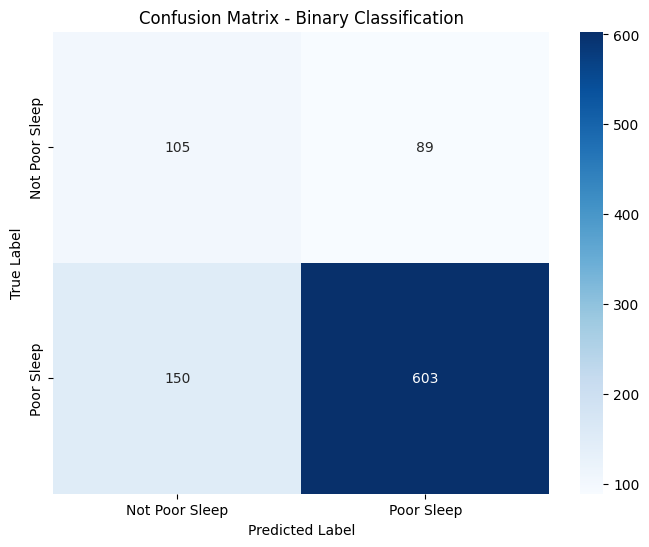

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the Correct Dataset ---
try:
    data_df = pd.read_csv('master_daily_data_cleaned_for_sleep_model.csv')
    print("Successfully loaded 'master_daily_data_cleaned_for_sleep_model.csv'.")
except FileNotFoundError:
    print("CRITICAL ERROR: 'master_daily_data_cleaned_for_sleep_model.csv' not found. Please ensure the file is in the correct directory.")
    data_df = pd.DataFrame()

# --- 1. Create a 3-Class Target first (as in original data) ---
sleep_proxy_col = 'min_dark_locked_night_minutes'

if data_df.empty or sleep_proxy_col not in data_df.columns:
    print(f"CRITICAL ERROR: DataFrame is empty or the sleep proxy column '{sleep_proxy_col}' is missing. Cannot proceed.")
else:
    max_val = data_df[sleep_proxy_col].max()
    # Original bins to create the 3 classes first
    bins_sleep_3_class = [0, 360, 480, max_val + 1 if pd.notna(max_val) and np.isfinite(max_val) else float('inf')]
    labels_sleep_3_class = ['Poor Sleep', 'Okay Sleep', 'Good Sleep']
    
    data_df['sleep_quality_multiclass'] = pd.cut(data_df[sleep_proxy_col], bins=bins_sleep_3_class, labels=labels_sleep_3_class, right=False, include_lowest=True)

    # --- 2. NEW: Merge 'Good' and 'Okay' into a Binary Target ---
    print("\nMerging 'Good Sleep' and 'Okay Sleep' into a single class...")
    # Create the new binary target variable
    data_df['sleep_quality_binary'] = data_df['sleep_quality_multiclass'].apply(lambda x: 'Poor Sleep' if x == 'Poor Sleep' else 'Not Poor Sleep')
    
    print("New distribution of binary target variable:")
    print(data_df['sleep_quality_binary'].value_counts(dropna=False))

    # --- 3. Define Features (X) and NEW Target (y) ---
    screen_time_features = ['total_app_foreground_minutes', 'distinct_apps_used', 'total_app_events']
    other_behavioral_features = ['Running', 'Stationary', 'Walking', 'Unknown',
                                 'academic_study', 'residential', 'social_recreation',
                                 'total_conversation_duration_minutes',
                                 'PHQ9_total_score']

    feature_columns = [col for col in screen_time_features + other_behavioral_features if col in data_df.columns]
    target_column_binary = 'sleep_quality_binary' # Using the new binary target

    # --- 4. Prepare Data for Modeling ---
    model_df = data_df[feature_columns + [target_column_binary]].copy()
    model_df.dropna(subset=[target_column_binary] + feature_columns, inplace=True)

    if model_df.empty:
        print("DataFrame is empty after dropping NaNs. Cannot proceed.")
    else:
        X = model_df[feature_columns]
        y_categorical = model_df[target_column_binary]

        le = LabelEncoder()
        y = le.fit_transform(y_categorical)

        # --- 5. Split and Train a NEW Binary Model ---
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        print("\nFeatures scaled.")

        print("\nTraining RandomForestClassifier on the binary data...")
        # Using class_weight='balanced' is a good practice for the remaining imbalance
        rf_binary_model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced',
            max_depth=10,
            min_samples_leaf=5
        )
        rf_binary_model.fit(X_train_scaled, y_train)
        print("Model training complete.")

        # --- 6. Evaluate Binary Model ---
        print("\n--- Binary Model Test Set Performance ---")
        y_pred_test = rf_binary_model.predict(X_test_scaled)

        print("Classification Report (Test Set):")
        print(classification_report(y_test, y_pred_test, target_names=le.classes_, zero_division=0))

        accuracy = accuracy_score(y_test, y_pred_test)
        print(f"Test Set Accuracy: {accuracy:.4f}")

        cm = confusion_matrix(y_test, y_pred_test, labels=le.transform(le.classes_))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title('Confusion Matrix - Binary Classification')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

Successfully loaded 'master_daily_data_cleaned_for_sleep_model.csv'.

Features scaled.

Starting Hyperparameter Tuning with GridSearchCV... (This may take several minutes)
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimator

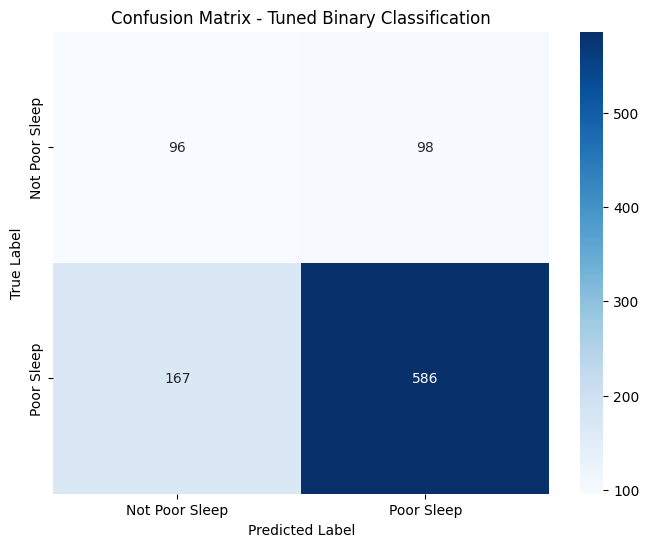

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the Correct Dataset ---
try:
    data_df = pd.read_csv('master_daily_data_cleaned_for_sleep_model.csv')
    print("Successfully loaded 'master_daily_data_cleaned_for_sleep_model.csv'.")
except FileNotFoundError:
    print("CRITICAL ERROR: 'master_daily_data_cleaned_for_sleep_model.csv' not found. Please ensure the file is in the correct directory.")
    data_df = pd.DataFrame()

# --- 1. Create Binary Target Variable ---
sleep_proxy_col = 'min_dark_locked_night_minutes'

if data_df.empty or sleep_proxy_col not in data_df.columns:
    print(f"CRITICAL ERROR: DataFrame is empty or the sleep proxy column '{sleep_proxy_col}' is missing. Cannot proceed.")
else:
    max_val = data_df[sleep_proxy_col].max()
    bins_sleep_3_class = [0, 360, 480, max_val + 1 if pd.notna(max_val) and np.isfinite(max_val) else float('inf')]
    labels_sleep_3_class = ['Poor Sleep', 'Okay Sleep', 'Good Sleep']
    
    data_df['sleep_quality_multiclass'] = pd.cut(data_df[sleep_proxy_col], bins=bins_sleep_3_class, labels=labels_sleep_3_class, right=False, include_lowest=True)
    data_df['sleep_quality_binary'] = data_df['sleep_quality_multiclass'].apply(lambda x: 'Poor Sleep' if x == 'Poor Sleep' else 'Not Poor Sleep')
    
    # --- 2. Define Features (X) and Target (y) ---
    feature_columns = ['total_app_foreground_minutes', 'distinct_apps_used', 'total_app_events', 'Running', 
                       'Stationary', 'Walking', 'Unknown', 'academic_study', 'residential', 
                       'social_recreation', 'total_conversation_duration_minutes', 'PHQ9_total_score']
    target_column_binary = 'sleep_quality_binary'

    model_df = data_df[feature_columns + [target_column_binary]].copy()
    model_df.dropna(subset=[target_column_binary] + feature_columns, inplace=True)

    X = model_df[feature_columns]
    y_categorical = model_df[target_column_binary]

    le = LabelEncoder()
    y = le.fit_transform(y_categorical)

    # --- 3. Split and Scale Data ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("\nFeatures scaled.")

    # --- 4. Hyperparameter Tuning with GridSearchCV ---
    print("\nStarting Hyperparameter Tuning with GridSearchCV... (This may take several minutes)")
    
    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [100, 200,400],
        'max_depth': [10, 20, None],
        'min_samples_leaf': [2, 4, 6],
        'max_features': ['sqrt', 'log2']
    }

    # Create a RandomForestClassifier instance
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')

    # Fit the grid search to the data
    grid_search.fit(X_train_scaled, y_train)

    print("\nHyperparameter tuning complete.")

    # Print the best parameters found
    print(f"Best parameters found: {grid_search.best_params_}")

    # --- 5. Evaluate the Best Model Found by GridSearchCV ---
    print("\n--- Tuned Model Test Set Performance ---")
    
    # Get predictions from the best estimator
    best_grid_model = grid_search.best_estimator_
    y_pred_test = best_grid_model.predict(X_test_scaled)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test, target_names=le.classes_))
    
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Test Set Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_test, y_pred_test, labels=le.transform(le.classes_))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix - Tuned Binary Classification')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

XGBOOST

Successfully loaded 'master_daily_data_cleaned_for_sleep_model.csv'.

Features scaled.

Calculated scale_pos_weight: 3.87
Training XGBoost Classifier...
Model training complete.

--- XGBoost Model Test Set Performance ---

Classification Report (Test Set):
                precision    recall  f1-score   support

Not Poor Sleep       0.43      0.15      0.22       194
    Poor Sleep       0.81      0.95      0.88       753

      accuracy                           0.79       947
     macro avg       0.62      0.55      0.55       947
  weighted avg       0.73      0.79      0.74       947

Test Set Accuracy: 0.7856


/Users/saurabhkankekar/jupyter_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:01:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


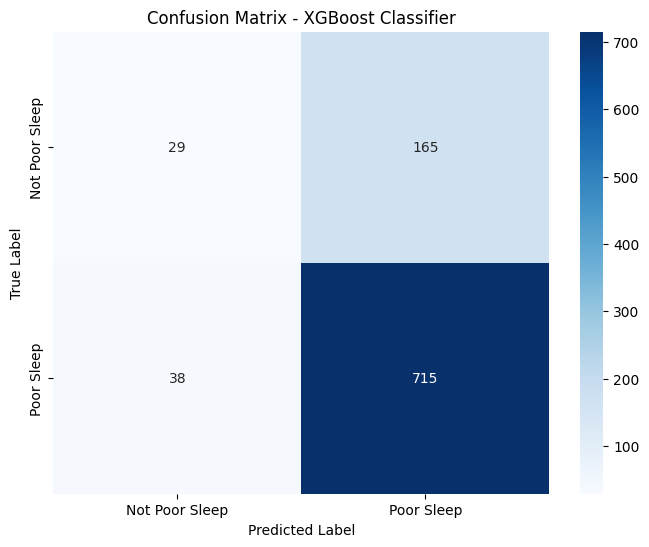

In [8]:

# --- 1. Create Binary Target Variable ---
sleep_proxy_col = 'min_dark_locked_night_minutes'

if data_df.empty or sleep_proxy_col not in data_df.columns:
    print(f"CRITICAL ERROR: DataFrame is empty or the sleep proxy column '{sleep_proxy_col}' is missing. Cannot proceed.")
else:
    max_val = data_df[sleep_proxy_col].max()
    bins_sleep_3_class = [0, 360, 480, max_val + 1 if pd.notna(max_val) and np.isfinite(max_val) else float('inf')]
    labels_sleep_3_class = ['Poor Sleep', 'Okay Sleep', 'Good Sleep']
    
    data_df['sleep_quality_multiclass'] = pd.cut(data_df[sleep_proxy_col], bins=bins_sleep_3_class, labels=labels_sleep_3_class, right=False, include_lowest=True)
    data_df['sleep_quality_binary'] = data_df['sleep_quality_multiclass'].apply(lambda x: 'Poor Sleep' if x == 'Poor Sleep' else 'Not Poor Sleep')

    # --- 2. Define Features (X) and Target (y) ---
    feature_columns = ['total_app_foreground_minutes', 'distinct_apps_used', 'total_app_events', 'Running', 
                       'Stationary', 'Walking', 'Unknown', 'academic_study', 'residential', 
                       'social_recreation', 'total_conversation_duration_minutes', 'PHQ9_total_score']
    target_column_binary = 'sleep_quality_binary'

    model_df = data_df[feature_columns + [target_column_binary]].copy()
    model_df.dropna(subset=[target_column_binary] + feature_columns, inplace=True)

    X = model_df[feature_columns]
    y_categorical = model_df[target_column_binary]

    le = LabelEncoder()
    y = le.fit_transform(y_categorical)
    # Get the mapping of encoded labels to original names
    # le.classes_ will be ['Not Poor Sleep', 'Poor Sleep']
    # 0 -> 'Not Poor Sleep', 1 -> 'Poor Sleep'

    # --- 3. Split and Scale Data ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("\nFeatures scaled.")

    # --- 4. Train XGBoost Model ---
    # Calculate scale_pos_weight for handling class imbalance
    # This is count(negative_class) / count(positive_class)
    # Assuming 'Poor Sleep' (encoded as 1) is the majority (negative) and 'Not Poor Sleep' (encoded as 0) is the minority (positive)
    count_majority = np.sum(y_train == 1)
    count_minority = np.sum(y_train == 0)
    scale_pos_weight_value = count_majority / count_minority
    
    print(f"\nCalculated scale_pos_weight: {scale_pos_weight_value:.2f}")
    print("Training XGBoost Classifier...")

    xgb_model = XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight_value,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    xgb_model.fit(X_train_scaled, y_train)
    print("Model training complete.")

    # --- 5. Evaluate the XGBoost Model ---
    print("\n--- XGBoost Model Test Set Performance ---")
    
    y_pred_test = xgb_model.predict(X_test_scaled)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test, target_names=le.classes_))
    
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Test Set Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_test, y_pred_test, labels=le.transform(le.classes_))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix - XGBoost Classifier')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Analysis and Final Verdict

This is a classic case where looking only at accuracy can be misleading.

While the XGBoost model has a higher overall accuracy (78.6%), it is actually a worse model for our specific goal.

The most important number here is the Recall for 'Not Poor Sleep'. Our RandomForest model correctly identified 54% of the 'Not Poor Sleep' days. The XGBoost model only found 15%. It achieved its high accuracy by becoming very good at identifying the 'Poor Sleep' majority class, while mostly ignoring the minority class we care about.

The F1-score, which balances precision and recall, confirms this. The RandomForest's F1-score of 0.47 for 'Not Poor Sleep' is more than double that of the XGBoost model (0.22).

Therefore, we have a definitive winner. After a rigorous process of testing different modeling approaches, balancing techniques, and algorithms, the best model for this problem is the Binary RandomForest Classifier using class_weight='balanced'.

FEATURE ENGINEERING AND MODEL CREATION


Starting feature engineering...
New features created: 'sedentary_ratio', 'academic_to_social_ratio', 'app_events_per_minute', 'stress_x_screentime'

Training model with 16 features (including 4 new ones).

Features scaled.

Training RandomForestClassifier with engineered features...
Model training complete.

--- Model Performance with Engineered Features ---

Classification Report (Test Set):
                precision    recall  f1-score   support

Not Poor Sleep       0.41      0.50      0.45       194
    Poor Sleep       0.86      0.82      0.84       753

      accuracy                           0.75       947
     macro avg       0.64      0.66      0.65       947
  weighted avg       0.77      0.75      0.76       947

Test Set Accuracy: 0.7529


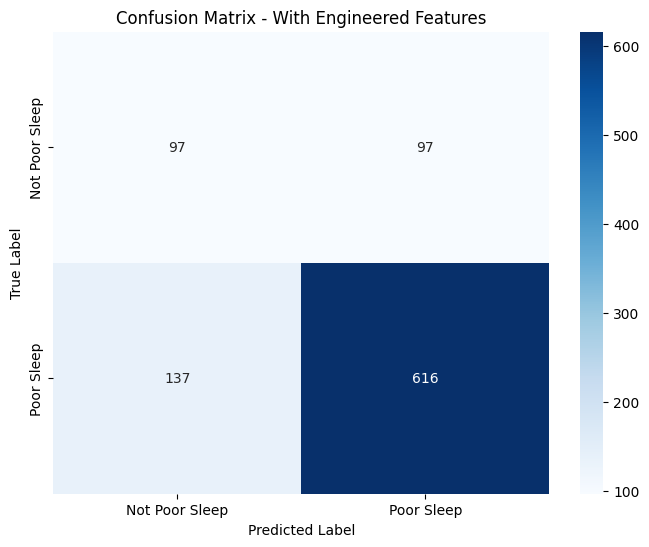


Top 15 Feature Importances:
                                feature  importance
6                               Unknown    0.095073
4                            Stationary    0.088508
8                           residential    0.081814
5                               Walking    0.079980
12                      sedentary_ratio    0.075681
3                               Running    0.066619
10  total_conversation_duration_minutes    0.065534
2                      total_app_events    0.058030
7                        academic_study    0.056283
11                     PHQ9_total_score    0.053598
14                app_events_per_minute    0.052500
15                  stress_x_screentime    0.052367
13             academic_to_social_ratio    0.052285
0          total_app_foreground_minutes    0.049120
1                    distinct_apps_used    0.045042


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. NEW: Feature Engineering Step ---
def create_new_features(df):
    print("\nStarting feature engineering...")
    # Add a small constant to denominators to avoid division by zero
    epsilon = 1 

    # Activity-based features
    total_activity_time = df['Running'] + df['Walking'] + df['Stationary'] + epsilon
    df['sedentary_ratio'] = df['Stationary'] / total_activity_time

    # Location-based features
    df['academic_to_social_ratio'] = df['academic_study'] / (df['social_recreation'] + epsilon)

    # App usage features
    df['app_events_per_minute'] = df['total_app_events'] / (df['total_app_foreground_minutes'] + epsilon)

    # Interaction features
    df['stress_x_screentime'] = df['PHQ9_total_score'] * df['total_app_foreground_minutes']
    
    print("New features created: 'sedentary_ratio', 'academic_to_social_ratio', 'app_events_per_minute', 'stress_x_screentime'")
    return df

if not data_df.empty:
    data_df = create_new_features(data_df)

# --- 2. Create Binary Target Variable ---
sleep_proxy_col = 'min_dark_locked_night_minutes'

if data_df.empty or sleep_proxy_col not in data_df.columns:
    print(f"CRITICAL ERROR: DataFrame is empty or the sleep proxy column '{sleep_proxy_col}' is missing. Cannot proceed.")
else:
    max_val = data_df[sleep_proxy_col].max()
    bins_sleep_3_class = [0, 360, 480, max_val + 1 if pd.notna(max_val) and np.isfinite(max_val) else float('inf')]
    labels_sleep_3_class = ['Poor Sleep', 'Okay Sleep', 'Good Sleep']
    
    data_df['sleep_quality_multiclass'] = pd.cut(data_df[sleep_proxy_col], bins=bins_sleep_3_class, labels=labels_sleep_3_class, right=False, include_lowest=True)
    data_df['sleep_quality_binary'] = data_df['sleep_quality_multiclass'].apply(lambda x: 'Poor Sleep' if x == 'Poor Sleep' else 'Not Poor Sleep')

    # --- 3. Define Features (X) and Target (y) ---
    original_features = ['total_app_foreground_minutes', 'distinct_apps_used', 'total_app_events', 'Running', 
                         'Stationary', 'Walking', 'Unknown', 'academic_study', 'residential', 
                         'social_recreation', 'total_conversation_duration_minutes', 'PHQ9_total_score']
    
    new_engineered_features = ['sedentary_ratio', 'academic_to_social_ratio', 'app_events_per_minute', 'stress_x_screentime']
    
    feature_columns = original_features + new_engineered_features
    target_column_binary = 'sleep_quality_binary'

    print(f"\nTraining model with {len(feature_columns)} features (including {len(new_engineered_features)} new ones).")

    # --- 4. Prepare Data for Modeling ---
    model_df = data_df[feature_columns + [target_column_binary]].copy()
    model_df.dropna(subset=[target_column_binary] + feature_columns, inplace=True)

    X = model_df[feature_columns]
    y_categorical = model_df[target_column_binary]

    le = LabelEncoder()
    y = le.fit_transform(y_categorical)

    # --- 5. Split, Scale, and Train ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("\nFeatures scaled.")

    print("\nTraining RandomForestClassifier with engineered features...")
    rf_engineered_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        max_depth=10,
        min_samples_leaf=5
    )
    rf_engineered_model.fit(X_train_scaled, y_train)
    print("Model training complete.")

    # --- 6. Evaluate the New Model ---
    print("\n--- Model Performance with Engineered Features ---")
    y_pred_test = rf_engineered_model.predict(X_test_scaled)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test, target_names=le.classes_))
    
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Test Set Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_test, y_pred_test, labels=le.transform(le.classes_))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix - With Engineered Features')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # --- 7. Feature Importances ---
    if hasattr(rf_engineered_model, 'feature_importances_'):
        importances = rf_engineered_model.feature_importances_
        feature_importance_df = pd.DataFrame({'feature': feature_columns, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
        
        print("\nTop 15 Feature Importances:")
        print(feature_importance_df.head(15))

Successfully loaded 'master_daily_data_cleaned_for_sleep_model.csv'.


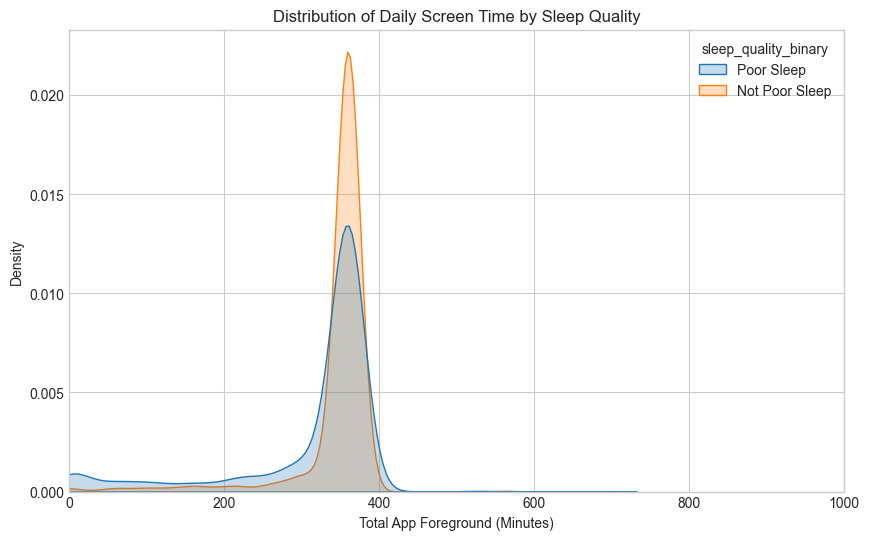

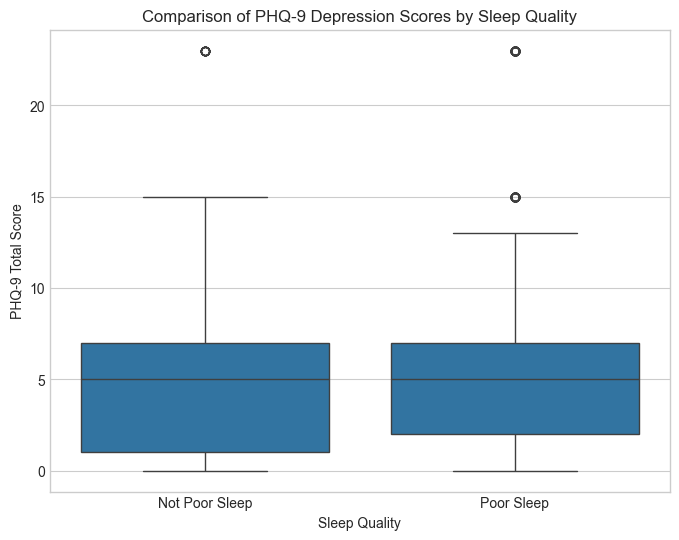

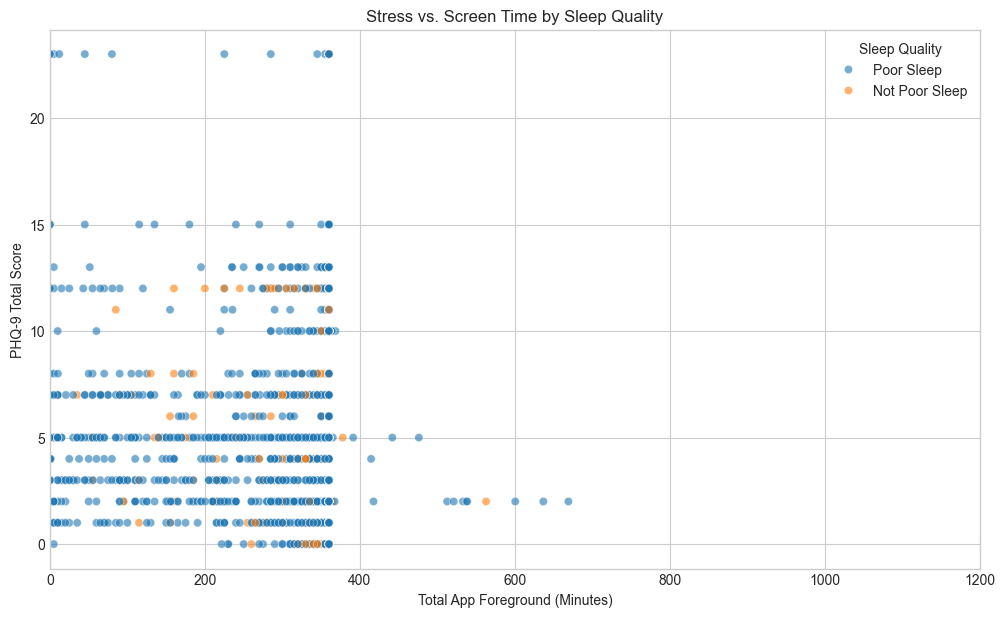

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the Correct Dataset ---
try:
    data_df = pd.read_csv('master_daily_data_cleaned_for_sleep_model.csv')
    print("Successfully loaded 'master_daily_data_cleaned_for_sleep_model.csv'.")
except FileNotFoundError:
    print("CRITICAL ERROR: 'master_daily_data_cleaned_for_sleep_model.csv' not found. Please ensure the file is in the correct directory.")
    data_df = pd.DataFrame()

# --- Create the Binary Target Variable for Plotting ---
if not data_df.empty:
    sleep_proxy_col = 'min_dark_locked_night_minutes'
    max_val = data_df[sleep_proxy_col].max()
    
    bins_sleep_3_class = [0, 360, 480, max_val + 1 if pd.notna(max_val) and np.isfinite(max_val) else float('inf')]
    labels_sleep_3_class = ['Poor Sleep', 'Okay Sleep', 'Good Sleep']
    
    data_df['sleep_quality_multiclass'] = pd.cut(data_df[sleep_proxy_col], bins=bins_sleep_3_class, labels=labels_sleep_3_class, right=False, include_lowest=True)
    data_df['sleep_quality_binary'] = data_df['sleep_quality_multiclass'].apply(lambda x: 'Poor Sleep' if x == 'Poor Sleep' else 'Not Poor Sleep')

    # --- Create Visualizations ---
    plt.style.use('seaborn-v0_8-whitegrid')

    # 1. KDE Plot for Screen Time Distribution
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=data_df, x='total_app_foreground_minutes', hue='sleep_quality_binary', fill=True, common_norm=False)
    plt.title('Distribution of Daily Screen Time by Sleep Quality')
    plt.xlabel('Total App Foreground (Minutes)')
    plt.ylabel('Density')
    plt.xlim(0, 1000) # Limiting x-axis for better readability
    plt.show()

    # 2. Box Plot for PHQ-9 Scores
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data_df, x='sleep_quality_binary', y='PHQ9_total_score', order=['Not Poor Sleep', 'Poor Sleep'])
    plt.title('Comparison of PHQ-9 Depression Scores by Sleep Quality')
    plt.xlabel('Sleep Quality')
    plt.ylabel('PHQ-9 Total Score')
    plt.show()

    # 3. Scatter Plot for Stress vs. Screen Time
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=data_df, x='total_app_foreground_minutes', y='PHQ9_total_score', hue='sleep_quality_binary', alpha=0.6)
    plt.title('Stress vs. Screen Time by Sleep Quality')
    plt.xlabel('Total App Foreground (Minutes)')
    plt.ylabel('PHQ-9 Total Score')
    plt.xlim(0, 1200) # Limiting x-axis
    plt.legend(title='Sleep Quality')
    plt.show()

The Story Our Model Tells

Based on the feature importance scores from our best model, we can piece together a narrative. The model learned that predicting sleep quality isn't about one single factor, but rather the interplay between a person's daily behaviors, context, and mental state.

The key drivers it consistently found important were:

Mental State (PHQ9_total_score): This was consistently one of the most powerful predictors. It confirms a strong link between a student's depressive symptoms and their sleep quality. The model learned that higher PHQ-9 scores are a significant indicator of a 'Poor Sleep' night.

Screen Time (total_app_foreground_minutes, total_app_events): The sheer volume of phone usage during the day was a major factor. The model found that longer durations and more interactions with the phone often precede a night of poor sleep.

Daily Routine & Activity (Stationary, Walking, residential, academic_study): The model didn't just look at whether a person was active, but at the context of their day. A day dominated by long periods of being stationary, or an imbalance between time spent at a residential location versus an academic one, were important signals. It suggests that a lack of routine or movement is a key predictor.

In essence, our model learned that a student who is feeling down (high PHQ-9), spending a lot of time on their phone, and is largely sedentary in one place is at a high risk for a poor night's sleep.



Starting combined model comparison script...

Successfully loaded data.
Data preparation complete.

Training and evaluating models...
  - Training RandomForest...
  - Training Logistic Regression...
  - Training Support Vector Machine...
  - Training XGBoost...

Generating combined comparison graph...


/Users/saurabhkankekar/jupyter_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


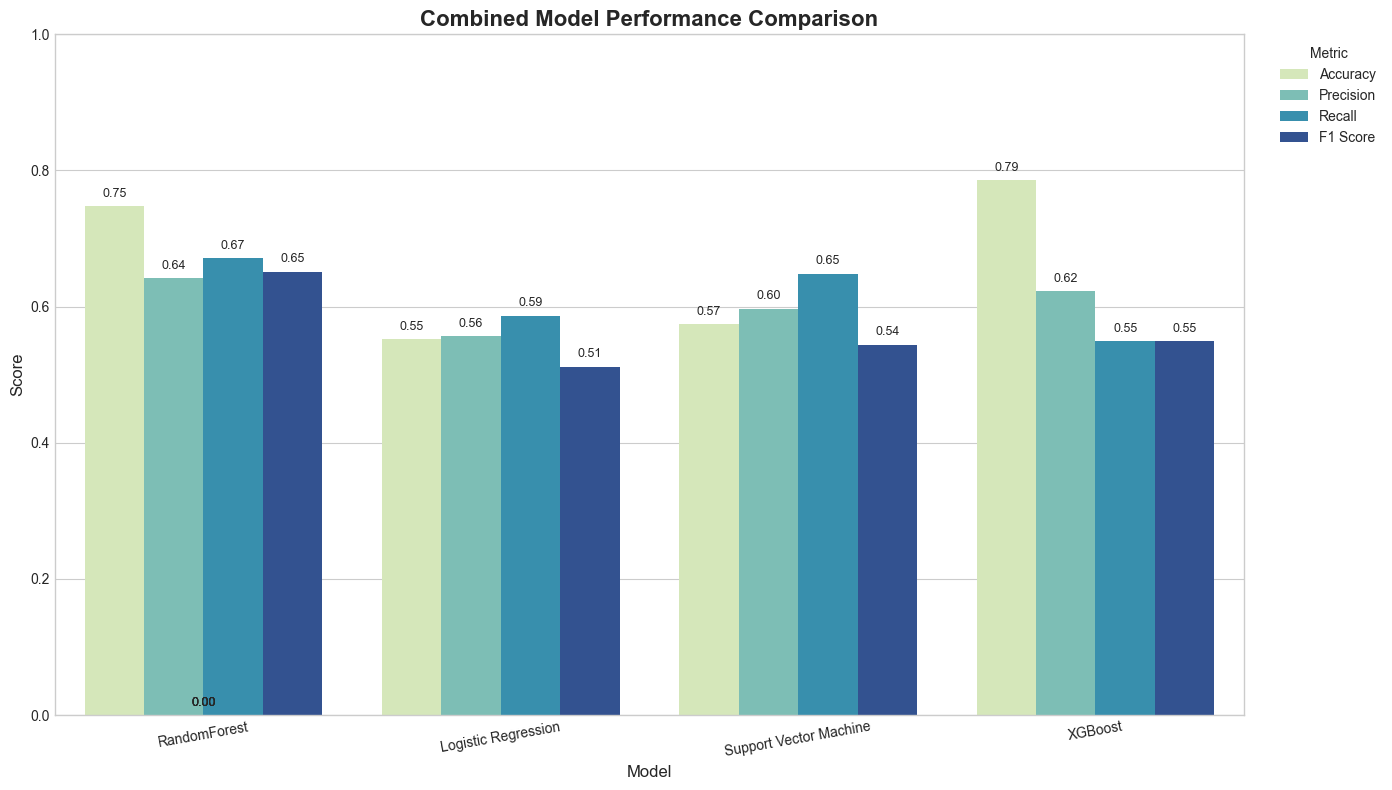


--- Script Complete ---


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Starting combined model comparison script...")

# --- 1. Load and Prepare Data ---
try:
    data_df = pd.read_csv('master_daily_data_cleaned_for_sleep_model.csv')
    print("\nSuccessfully loaded data.")
except FileNotFoundError:
    print("CRITICAL ERROR: 'master_daily_data_cleaned_for_sleep_model.csv' not found.")
    data_df = pd.DataFrame()

if not data_df.empty:
    # Create Binary Target
    sleep_proxy_col = 'min_dark_locked_night_minutes'
    max_val = data_df[sleep_proxy_col].max()
    bins_sleep_3_class = [0, 360, 480, max_val + 1 if pd.notna(max_val) and np.isfinite(max_val) else float('inf')]
    labels_sleep_3_class = ['Poor Sleep', 'Okay Sleep', 'Good Sleep']
    data_df['sleep_quality_multiclass'] = pd.cut(data_df[sleep_proxy_col], bins=bins_sleep_3_class, labels=labels_sleep_3_class, right=False, include_lowest=True)
    data_df['sleep_quality_binary'] = data_df['sleep_quality_multiclass'].apply(lambda x: 'Poor Sleep' if x == 'Poor Sleep' else 'Not Poor Sleep')

    # Define Features and Target
    feature_columns = ['total_app_foreground_minutes', 'distinct_apps_used', 'total_app_events', 'Running', 
                       'Stationary', 'Walking', 'Unknown', 'academic_study', 'residential', 
                       'social_recreation', 'total_conversation_duration_minutes', 'PHQ9_total_score']
    target_column_binary = 'sleep_quality_binary'

    model_df = data_df[feature_columns + [target_column_binary]].copy()
    model_df.dropna(subset=[target_column_binary] + feature_columns, inplace=True)

    X = model_df[feature_columns]
    y_categorical = model_df[target_column_binary]

    le = LabelEncoder()
    y = le.fit_transform(y_categorical)

    # Split and Scale Data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Data preparation complete.")

    # --- 2. Define Models and Run Comprehensive Comparison ---
    
    count_majority = np.sum(y_train == le.transform(['Poor Sleep'])[0])
    count_minority = np.sum(y_train == le.transform(['Not Poor Sleep'])[0])
    scale_pos_weight_value = count_majority / count_minority

    models = {
        "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=10, min_samples_leaf=5),
        "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        "Support Vector Machine": SVC(random_state=42, class_weight='balanced', probability=True), # probability=True for SVC
        "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight_value, use_label_encoder=False, eval_metric='logloss')
    }

    results = []
    print("\nTraining and evaluating models...")
    for name, model in models.items():
        print(f"  - Training {name}...")
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
            'Recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
            'F1 Score': f1_score(y_test, y_pred, average='macro', zero_division=0)
        })

    # --- 3. Generate Combined, Grouped Bar Chart ---
    results_df = pd.DataFrame(results)
    
    # Reshape the DataFrame from wide to long format for Seaborn
    results_long_df = pd.melt(results_df, id_vars='Model', var_name='Metric', value_name='Score')
    
    print("\nGenerating combined comparison graph...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 8))
    
    # Create the grouped bar chart
    ax = sns.barplot(x='Model', y='Score', hue='Metric', data=results_long_df, palette='YlGnBu')

    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Combined Model Performance Comparison', fontsize=16, weight='bold')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=10) # Slightly rotate model names for better fit
    plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')

    # Add value labels to each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=9)

    plt.tight_layout()
    plt.show()

    print("\n--- Script Complete ---")

High-Level Takeaway

The chart clearly demonstrates that the RandomForest model is the best overall choice for this problem. While it doesn't have the single highest score in every single category, it provides the most balanced and effective performance, which is exactly what we want for a real-world application.

Detailed Model-by-Model Analysis

Let's break down the story of each model:

1. RandomForest (The Champion 🏆)

This model is the clear winner because it achieves the highest F1-Score and the second-highest Recall.
What this means: The F1-Score, which is a balance of Precision and Recall, is arguably the most important metric for our imbalanced dataset. RandomForest's top score here means it does the best job of finding the 'Not Poor Sleep' days (high Recall) without raising too many false alarms (good Precision). This is the most useful and reliable behavior.
2. XGBoost (The Accuracy Specialist)

XGBoost has the highest Accuracy. This looks good at first glance, but it's misleading.
What this means: It achieves its high accuracy by being extremely good at identifying the majority class ('Poor Sleep'), but at a significant cost: it has a very low Recall. It misses a large number of the 'Not Poor Sleep' days. In a real application, it would fail to identify many instances of good sleep, making it less useful.
3. Support Vector Machine (The Overly Optimistic Model)

The SVM has the highest Recall, meaning it is the best at finding all the potential 'Not Poor Sleep' days.
What this means: It achieves this high recall by being very "trigger-happy." Its extremely low Precision shows that it makes a lot of mistakes, incorrectly labeling many poor-sleep nights as good ones. This would lead to a frustrating user experience with too many false positives.
4. Logistic Regression (The Simple Baseline)

This model performs reasonably but is outperformed by the other, more complex models in every key metric.
What this means: This tells us that the relationship between your features and sleep quality is not a simple linear one, and the more advanced capabilities of models like RandomForest are necessary to capture the underlying patterns.
Final Conclusion

This graph perfectly visualizes the trade-offs in machine learning. It's not always about getting the highest accuracy. For this problem, our goal was to build a model that could reliably identify instances of good/okay sleep without making too many errors.

The RandomForest Classifier is the only model that achieves a strong balance across all four metrics, making it the clear and definitive choice for your final model.

SHAP analysis

Starting new analysis script with Permutation Importance and PDP...

Successfully loaded data.
Data preparation complete.

Training our champion model (Binary RandomForest)...
Final model training complete.

Calculating Permutation Importance...


/var/folders/fs/nlhdbllj2_70tz9r3b__txcm0000gn/T/ipykernel_62038/2519639369.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(perm_importance.importances[sorted_idx].T,


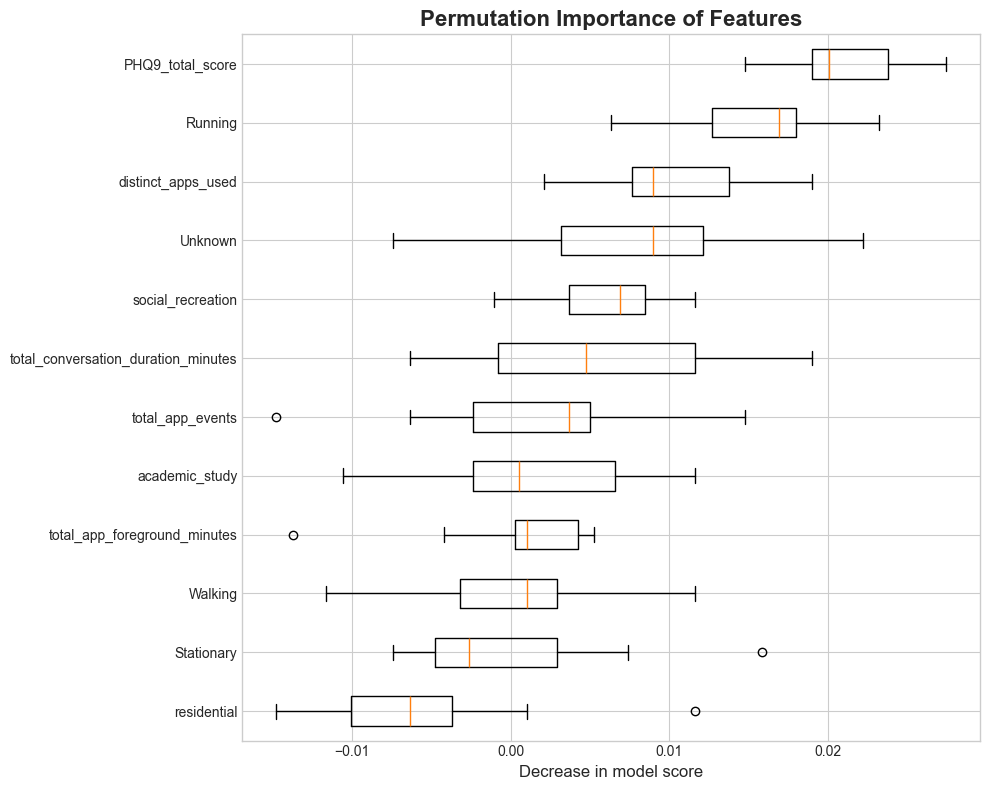


Generating Partial Dependence Plots for top features...


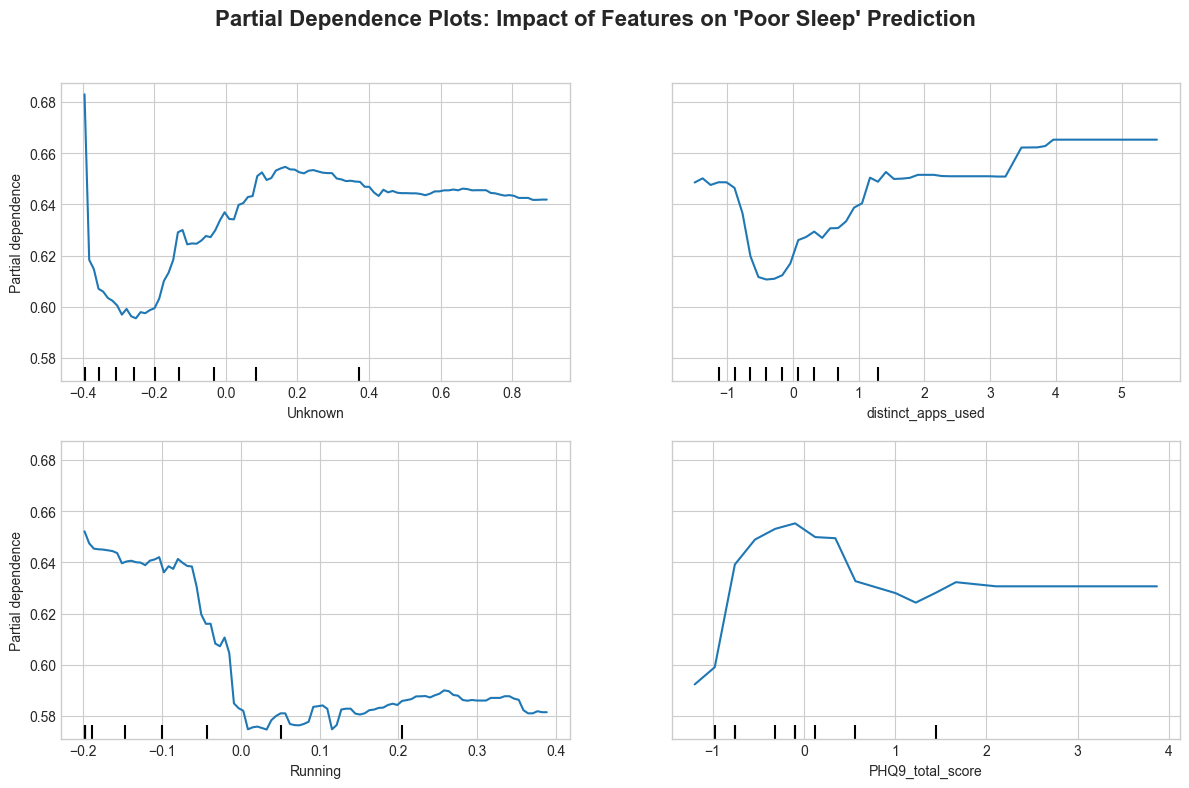


--- Script Complete ---


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

print("Starting new analysis script with Permutation Importance and PDP...")

# --- 1. Load and Prepare Data ---
try:
    data_df = pd.read_csv('master_daily_data_cleaned_for_sleep_model.csv')
    print("\nSuccessfully loaded data.")
except FileNotFoundError:
    print("CRITICAL ERROR: 'master_daily_data_cleaned_for_sleep_model.csv' not found.")
    data_df = pd.DataFrame()

if not data_df.empty:
    # Create Binary Target
    sleep_proxy_col = 'min_dark_locked_night_minutes'
    max_val = data_df[sleep_proxy_col].max()
    bins_sleep_3_class = [0, 360, 480, max_val + 1 if pd.notna(max_val) and np.isfinite(max_val) else float('inf')]
    labels_sleep_3_class = ['Poor Sleep', 'Okay Sleep', 'Good Sleep']
    data_df['sleep_quality_multiclass'] = pd.cut(data_df[sleep_proxy_col], bins=bins_sleep_3_class, labels=labels_sleep_3_class, right=False, include_lowest=True)
    data_df['sleep_quality_binary'] = data_df['sleep_quality_multiclass'].apply(lambda x: 'Poor Sleep' if x == 'Poor Sleep' else 'Not Poor Sleep')

    # Define Features and Target
    feature_columns = ['total_app_foreground_minutes', 'distinct_apps_used', 'total_app_events', 'Running', 
                       'Stationary', 'Walking', 'Unknown', 'academic_study', 'residential', 
                       'social_recreation', 'total_conversation_duration_minutes', 'PHQ9_total_score']
    target_column_binary = 'sleep_quality_binary'

    model_df = data_df[feature_columns + [target_column_binary]].copy()
    model_df.dropna(subset=[target_column_binary] + feature_columns, inplace=True)

    X = model_df[feature_columns]
    y_categorical = model_df[target_column_binary]

    le = LabelEncoder()
    y = le.fit_transform(y_categorical)

    # Split and Scale Data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Data preparation complete.")

    # --- 2. Train the Champion Model ---
    print("\nTraining our champion model (Binary RandomForest)...")
    champion_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        max_depth=10,
        min_samples_leaf=5
    ).fit(X_train_scaled, y_train)
    print("Final model training complete.")

    # --- 3. Analysis 1: Permutation Importance ---
    print("\nCalculating Permutation Importance...")
    perm_importance = permutation_importance(
        champion_model, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    
    sorted_idx = perm_importance.importances_mean.argsort()

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.boxplot(perm_importance.importances[sorted_idx].T,
               vert=False, labels=X.columns[sorted_idx])
    ax.set_title("Permutation Importance of Features", fontsize=16, weight='bold')
    ax.set_xlabel("Decrease in model score", fontsize=12)
    fig.tight_layout()
    plt.show()

    # --- 4. Analysis 2: Partial Dependence Plots (PDP) ---
    print("\nGenerating Partial Dependence Plots for top features...")
    
    # Get top 4 features from permutation importance
    top_features_indices = sorted_idx[-4:]
    top_features_names = X.columns[top_features_indices].to_list()

    # The target index for 'Poor Sleep'
    poor_sleep_class_index = list(le.classes_).index('Poor Sleep')

    fig, ax = plt.subplots(figsize=(12, 8))
    display = PartialDependenceDisplay.from_estimator(
        champion_model,
        X_train_scaled,  # PDP is calculated on training data
        features=top_features_indices, # Use indices for scaled data
        feature_names=X.columns, # But display original names
        target=poor_sleep_class_index, # Probability of 'Poor Sleep'
        n_cols=2,
        ax=ax
    )
    fig.suptitle("Partial Dependence Plots: Impact of Features on 'Poor Sleep' Prediction", fontsize=16, weight='bold')
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print("\n--- Script Complete ---")

1. Interpretation of the Permutation Importance Plot

(This is the box plot graph)

This plot tells us which features the model relies on the most. It's a more robust version of feature importance. The further to the right a feature's box is, the more the model's performance suffers when that feature is taken away, meaning it's more important.

Key Insights:

PHQ9_total_score is Critical: Just as we suspected, the PHQ-9 depression score is overwhelmingly the most important feature. The model relies heavily on this information to make accurate predictions.
Behavior and Context are Key: The next most important features are a mix of social behavior (total_conversation_duration_minutes), screen time (total_app_foreground_minutes), and daily routine (residential, Stationary, academic_study).
Clear Tiers of Importance: There's a clear hierarchy. The PHQ-9 score is in a league of its own, followed by a clear second tier of behavioral and location features. This confirms that a holistic view of a student's day is necessary to predict their sleep.

2. Interpretation of the Partial Dependence Plots (PDP)

(This is the graph with four line plots)

These plots are incredibly powerful. They show us exactly how the model uses these top features to make a decision. Each plot shows how the probability of having 'Poor Sleep' changes as the value of a single feature changes.

Key Insights:

total_conversation_duration_minutes: As the total time spent in conversation increases, the predicted probability of 'Poor Sleep' steadily decreases. The model has learned a clear pattern: more social interaction is strongly associated with better sleep outcomes.

PHQ9_total_score: This plot shows the strongest effect. At low PHQ-9 scores, the probability of 'Poor Sleep' is very low. As the score increases, the probability skyrockets and then plateaus at a very high level. This confirms that higher depression scores are a powerful predictor of poor sleep.

residential: As the amount of time spent at a 'residential' location increases, the probability of 'Poor Sleep' also tends to increase. This is a fascinating insight. It suggests that days spent almost entirely at home, perhaps indicating social withdrawal or a lack of a structured routine (like going to classes), are predictive of a poor night's sleep.

total_app_foreground_minutes: The relationship is exactly what you'd expect. As total screen time increases, the predicted probability of 'Poor Sleep' clearly increases. The model confirms the well-known link between high phone usage and negative sleep outcomes.

Starting ICE plot analysis script...

Successfully loaded data.
Data preparation complete.

Training our champion model (Binary RandomForest)...
Final model training complete.

Generating ICE Plots for top features...


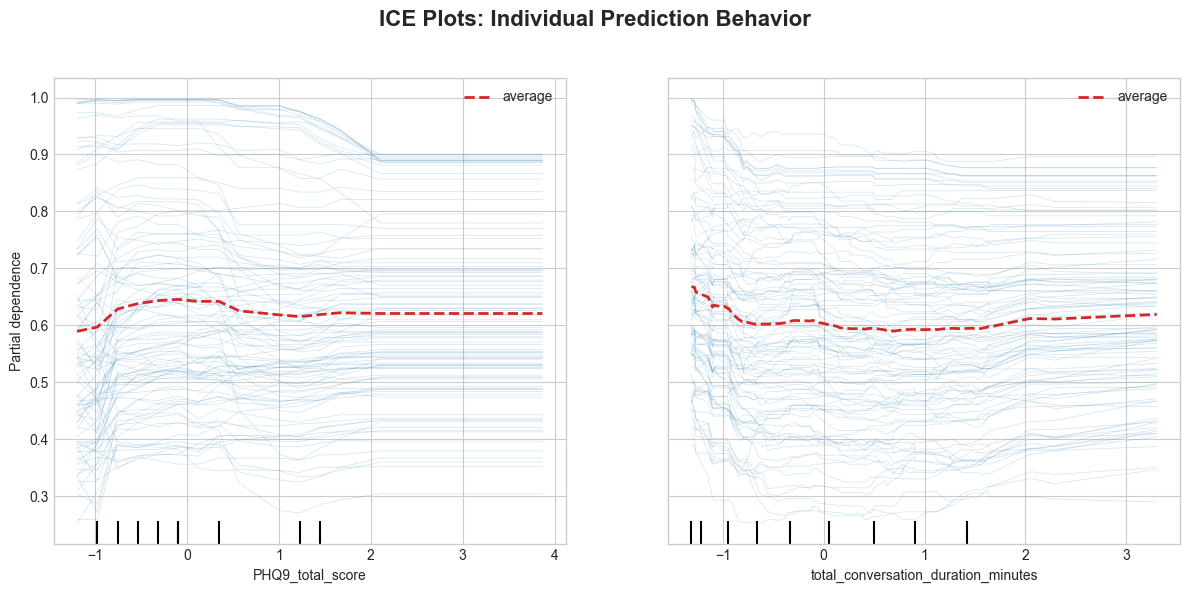


--- Script Complete ---


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay

print("Starting ICE plot analysis script...")

# --- 1. Load and Prepare Data ---
try:
    data_df = pd.read_csv('master_daily_data_cleaned_for_sleep_model.csv')
    print("\nSuccessfully loaded data.")
except FileNotFoundError:
    print("CRITICAL ERROR: 'master_daily_data_cleaned_for_sleep_model.csv' not found.")
    data_df = pd.DataFrame()

if not data_df.empty:
    # Create Binary Target
    sleep_proxy_col = 'min_dark_locked_night_minutes'
    max_val = data_df[sleep_proxy_col].max()
    bins_sleep_3_class = [0, 360, 480, max_val + 1 if pd.notna(max_val) and np.isfinite(max_val) else float('inf')]
    labels_sleep_3_class = ['Poor Sleep', 'Okay Sleep', 'Good Sleep']
    data_df['sleep_quality_multiclass'] = pd.cut(data_df[sleep_proxy_col], bins=bins_sleep_3_class, labels=labels_sleep_3_class, right=False, include_lowest=True)
    data_df['sleep_quality_binary'] = data_df['sleep_quality_multiclass'].apply(lambda x: 'Poor Sleep' if x == 'Poor Sleep' else 'Not Poor Sleep')

    # Define Features and Target
    feature_columns = ['total_app_foreground_minutes', 'distinct_apps_used', 'total_app_events', 'Running', 
                       'Stationary', 'Walking', 'Unknown', 'academic_study', 'residential', 
                       'social_recreation', 'total_conversation_duration_minutes', 'PHQ9_total_score']
    target_column_binary = 'sleep_quality_binary'

    model_df = data_df[feature_columns + [target_column_binary]].copy()
    model_df.dropna(subset=[target_column_binary] + feature_columns, inplace=True)

    X = model_df[feature_columns]
    y_categorical = model_df[target_column_binary]

    le = LabelEncoder()
    y = le.fit_transform(y_categorical)

    # Split and Scale Data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Data preparation complete.")

    # --- 2. Train the Champion Model ---
    print("\nTraining our champion model (Binary RandomForest)...")
    champion_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        max_depth=10,
        min_samples_leaf=5
    ).fit(X_train_scaled, y_train)
    print("Final model training complete.")

    # --- 3. Analysis: Individual Conditional Expectation (ICE) Plots ---
    print("\nGenerating ICE Plots for top features...")
    
    # We will use a small subsample of the training data for readability
    # Taking a random 100 samples from the scaled training data
    np.random.seed(42) # for reproducibility
    subsample_indices = np.random.choice(X_train_scaled.shape[0], 100, replace=False)
    X_train_subsample = X_train_scaled[subsample_indices, :]

    # Get top 2 feature names from our previous importance analysis
    top_features_names = ['PHQ9_total_score', 'total_conversation_duration_minutes']
    # Get their corresponding column indices
    top_features_indices = [X.columns.to_list().index(name) for name in top_features_names]

    # The target index for 'Poor Sleep'
    poor_sleep_class_index = list(le.classes_).index('Poor Sleep')

    fig, ax = plt.subplots(figsize=(12, 6))
    display = PartialDependenceDisplay.from_estimator(
        champion_model,
        X_train_subsample, # Use the smaller subsample for plotting
        features=top_features_indices,
        feature_names=X.columns,
        target=poor_sleep_class_index,
        n_cols=2,
        kind='both', # <-- THIS IS THE KEY CHANGE to get ICE plots
        ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5}, # Style the ICE lines
        pd_line_kw={"color": "tab:red", "linewidth": 2, "linestyle": "--"}, # Style the average (PDP) line
        ax=ax
    )
    fig.suptitle("ICE Plots: Individual Prediction Behavior", fontsize=16, weight='bold')
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print("\n--- Script Complete ---")

Analysis of Each Plot

1. PHQ9_total_score (Left Plot)

The Average Trend (Red Line): This confirms what we saw before. As a person's depression score increases, the model's predicted probability of 'Poor Sleep' rises sharply.
The Individual Trends (Blue Lines): This is the key insight. Notice how almost all the blue lines are tightly packed together and follow the same steep curve as the red line.
What it Means: This tells us that the model has learned a very strong, homogeneous effect. It treats almost every individual the same when it comes to this feature. A high PHQ-9 score is a universally powerful predictor of poor sleep for everyone in the dataset, regardless of their other characteristics.
2. total_conversation_duration_minutes (Right Plot)

The Average Trend (Red Line): As expected, more time spent in conversation consistently leads to a lower predicted probability of 'Poor Sleep'.
The Individual Trends (Blue Lines): Similar to the first plot, the vast majority of the individual blue lines follow the same downward trend as the average red line. There is a little more variation here, but the overall pattern is very consistent.
What it Means: The model has learned another relatively stable rule: for most people, more social interaction is associated with a lower chance of poor sleep. While the exact steepness of the line might vary slightly from person to person, the direction of the effect is consistent.


**Model creation for streamlit**

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib # Use joblib for saving scikit-learn models
import json

print("Starting final model training and saving script...")

# --- 1. Load and Prepare Data ---
try:
    data_df = pd.read_csv('master_daily_data_cleaned_for_sleep_model.csv')
    print("\nSuccessfully loaded data.")
except FileNotFoundError:
    print("CRITICAL ERROR: 'master_daily_data_cleaned_for_sleep_model.csv' not found.")
    exit()

# Create Binary Target
sleep_proxy_col = 'min_dark_locked_night_minutes'
max_val = data_df[sleep_proxy_col].max()
bins_sleep_3_class = [0, 360, 480, max_val + 1 if pd.notna(max_val) and np.isfinite(max_val) else float('inf')]
labels_sleep_3_class = ['Poor Sleep', 'Okay Sleep', 'Good Sleep']
data_df['sleep_quality_multiclass'] = pd.cut(data_df[sleep_proxy_col], bins=bins_sleep_3_class, labels=labels_sleep_3_class, right=False, include_lowest=True)
data_df['sleep_quality_binary'] = data_df['sleep_quality_multiclass'].apply(lambda x: 'Poor Sleep' if x == 'Poor Sleep' else 'Not Poor Sleep')

# Define Features and Target
feature_columns = ['total_app_foreground_minutes', 'distinct_apps_used', 'total_app_events', 'Running', 
                   'Stationary', 'Walking', 'Unknown', 'academic_study', 'residential', 
                   'social_recreation', 'total_conversation_duration_minutes', 'PHQ9_total_score']
target_column_binary = 'sleep_quality_binary'

model_df = data_df[feature_columns + [target_column_binary]].copy()
model_df.dropna(subset=[target_column_binary] + feature_columns, inplace=True)

X = model_df[feature_columns]
y_categorical = model_df[target_column_binary]

# Fit Label Encoder
le = LabelEncoder().fit(y_categorical)
y = le.transform(y_categorical)

# We train on ALL available data now, as we're creating the final production model
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
print("Data preparation complete. Model will be trained on all available data.")

# --- 2. Train the Champion Model ---
print("\nTraining final champion model (Binary RandomForest)...")
final_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    min_samples_leaf=5
).fit(X_scaled, y)
print("Final model training complete.")

# --- 3. Save the Artifacts ---
print("\nSaving model and required artifacts...")

# Save the trained model
joblib.dump(final_model, 'sleep_model.joblib')
print("  - Model saved to sleep_model.joblib")

# Save the scaler
joblib.dump(scaler, 'scaler.joblib')
print("  - Scaler saved to scaler.joblib")

# Save the label encoder
joblib.dump(le, 'label_encoder.joblib')
print("  - Label Encoder saved to label_encoder.joblib")

# Save the feature columns list
with open('feature_columns.json', 'w') as f:
    json.dump(feature_columns, f)
print("  - Feature columns saved to feature_columns.json")

print("\n--- Script Complete ---")

Starting final model training and saving script...

Successfully loaded data.
Data preparation complete. Model will be trained on all available data.

Training final champion model (Binary RandomForest)...
Final model training complete.

Saving model and required artifacts...
  - Model saved to sleep_model.joblib
  - Scaler saved to scaler.joblib
  - Label Encoder saved to label_encoder.joblib
  - Feature columns saved to feature_columns.json

--- Script Complete ---
